## Import Libraries and Loading Dataset

In [102]:
from google.colab import drive
import json
import numpy as np
import pandas as pd
import os
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.metrics import accuracy_score
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import plotly.graph_objects as go
from keras.layers import Embedding, Flatten, Dense, LSTM, Dropout
from keras.preprocessing.text import Tokenizer
import nltk
from nltk.stem import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import classification_report
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
import pickle

In [103]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
with open('/content/drive/MyDrive/AI Projects/intents.json') as file:
    data = json.load(file)

In [105]:
data

{'intents': [{'tag': 'greeting',
   'patterns': ['Hi',
    'Hey',
    'Is anyone there?',
    'Hi there',
    'Hello',
    'Hey there',
    'Howdy',
    'Hola',
    'Bonjour',
    'Konnichiwa',
    'Guten tag',
    'Ola'],
   'responses': ['Hello there. Tell me how are you feeling today?',
    'Hi there. What brings you here today?',
    'Hi there. How are you feeling today?',
    'Great to see you. How do you feel currently?',
    "Hello there. Glad to see you're back. What's going on in your world right now?"]},
  {'tag': 'morning',
   'patterns': ['Good morning'],
   'responses': ["Good morning. I hope you had a good night's sleep. How are you feeling today? "]},
  {'tag': 'afternoon',
   'patterns': ['Good afternoon'],
   'responses': ['Good afternoon. How is your day going?']},
  {'tag': 'evening',
   'patterns': ['Good evening'],
   'responses': ['Good evening. How has your day been?']},
  {'tag': 'night',
   'patterns': ['Good night'],
   'responses': ['Good night. Get some prop

## Tokenization and Encoding

In [106]:
# Initialize empty lists to store words, labels, and training data
words = []
labels = []
docs_x = []  # List to store tokenized patterns
docs_y = []  # List to store corresponding intent tags

# Iterate through each intent in the 'intents' data
for intent in data['intents']:
    # Iterate through each pattern in the current intent
    for pattern in intent['patterns']:
        # Tokenize the pattern into individual words
        tokenized_words = nltk.word_tokenize(pattern)

        # Extend the 'words' list with the tokenized words
        words.extend(tokenized_words)

        # Addd the tokenized words to 'docs_x'
        docs_x.append(tokenized_words)

        # Add the corresponding intent tag to 'docs_y'
        docs_y.append(intent["tag"])


    # Check if the intent tag is not already in the 'labels' list
    if intent['tag'] not in labels:
        # Add the intent tag to the 'labels' list
        labels.append(intent['tag'])


In [107]:
# Initialize a SnowballStemmer for English language
ss = SnowballStemmer(language='english')

#Convert each word to lowercase
lowercase_words = [w.lower() for w in words]

#Exclude "?" from the list of lowercase words
filtered_words = [w for w in lowercase_words if w != "?"]

#Apply stemming using SnowballStemmer
stemmed_words = [ss.stem(w) for w in filtered_words]

# Sort and create a unique set of stemmed words
words = sorted(list(set(stemmed_words)))

# Sort the list of unique intent tags ('labels')
labels = sorted(labels)

In [108]:
training = []  # List to store training data
output = []    # List to store corresponding output labels
out_empty = [0 for _ in range(len(labels))]  # List representing an empty output row

# Iterate through each document (tokenized and stemmed words) and its corresponding label
for x, doc in enumerate(docs_x):
    bag = []  # List to represent the bag of words for the current document

    # Stem and convert to lowercase each word in the document
    wrds = [ss.stem(w.lower()) for w in doc]

    # Iterate through the vocabulary (unique stemmed words)
    for w in words:
        # Check if the word is present in the document
        if w in wrds:
            bag.append(1)
        else:
            bag.append(0)

    # Create an output row with zeros and set the corresponding label to 1
    output_row = out_empty[:]
    output_row[labels.index(docs_y[x])] = 1

    # Append the bag of words and the output row to the training data
    training.append(bag)
    output.append(output_row)


## Split Dataset and Model Creation

In [109]:
training = np.array(training)
output = np.array(output)

In [110]:
#train_data, val_data, train_output, val_output = train_test_split(training, output, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(training,output, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=0.1, random_state=42)

In [111]:
# Build the model
model = Sequential()
model.add(Dense(8, input_shape=(len(training[0]),), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(len(output[0]), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history=model.fit(training, output, epochs=150, batch_size=8, validation_data=(X_test, y_test))

accuracy = model.evaluate(X_test, y_test)[1]
print(f"Test Accuracy: {accuracy * 100:.2f}%")

accuracy = model.evaluate(X_val, y_val)[1]
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Epoch 1/150
29/29 [==============================] - 1s 10ms/step - loss: 4.3762 - accuracy: 0.0216 - val_loss: 4.3623 - val_accuracy: 0.0426
Epoch 2/150
29/29 [==============================] - 0s 4ms/step - loss: 4.3567 - accuracy: 0.0474 - val_loss: 4.3450 - val_accuracy: 0.0638
Epoch 3/150
29/29 [==============================] - 0s 5ms/step - loss: 4.3366 - accuracy: 0.0603 - val_loss: 4.3220 - val_accuracy: 0.0638
Epoch 4/150
29/29 [==============================] - 0s 4ms/step - loss: 4.3104 - accuracy: 0.0690 - val_loss: 4.2920 - val_accuracy: 0.0851
Epoch 5/150
29/29 [==============================] - 0s 4ms/step - loss: 4.2742 - accuracy: 0.0690 - val_loss: 4.2490 - val_accuracy: 0.1064
Epoch 6/150
29/29 [==============================] - 0s 4ms/step - loss: 4.2257 - accuracy: 0.0603 - val_loss: 4.1908 - val_accuracy: 0.1064
Epoch 7/150
29/29 [==============================] - 0s 4ms/step - loss: 4.1632 - accuracy: 0.0647 - val_loss: 4.1292 - val_accuracy: 0.0851
Epoch 8/150


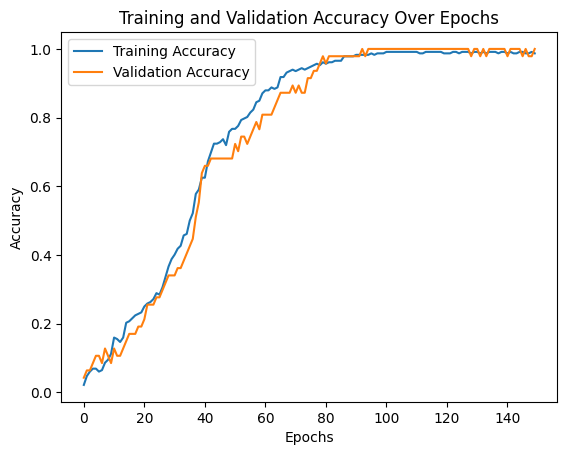

In [112]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()


In [113]:
def build_and_compile_model(input_shape, output_shape):
    model = Sequential()
    model.add(Dense(8, input_shape=(input_shape,), activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(output_shape, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


input_shape = len(training[0])
output_shape = len(output[0])

## Cross Validation

In [114]:
# Create KerasClassifier
keras_classifier = KerasClassifier(build_fn=build_and_compile_model, input_shape=input_shape, output_shape=output_shape)

# Define hyperparameter grid
param_grid = {
    'epochs': [100, 150, 200],
    'batch_size': [8,32, 64],

}

# Create GridSearchCV
grid_search = GridSearchCV(estimator=keras_classifier, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
results = grid_search.fit(training,output)

# Print the best parameters found
print("Best Parameters:", results.best_params_)



Epoch 1/200


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 6ms/step - loss: 4.3853 - accuracy: 0.0216
Epoch 2/200
8/8 [==============================] - 0s 5ms/step - loss: 4.3781 - accuracy: 0.0345
Epoch 3/200
8/8 [==============================] - 0s 5ms/step - loss: 4.3721 - accuracy: 0.0388
Epoch 4/200
8/8 [==============================] - 0s 5ms/step - loss: 4.3664 - accuracy: 0.0388
Epoch 5/200
8/8 [==============================] - 0s 6ms/step - loss: 4.3607 - accuracy: 0.0431
Epoch 6/200
8/8 [==============================] - 0s 6ms/step - loss: 4.3547 - accuracy: 0.0388
Epoch 7/200
8/8 [==============================] - 0s 6ms/step - loss: 4.3487 - accuracy: 0.0474
Epoch 8/200
8/8 [==============================] - 0s 5ms/step - loss: 4.3419 - accuracy: 0.0560
Epoch 9/200
8/8 [==============================] - 0s 5ms/step - loss: 4.3348 - accuracy: 0.0603
Epoch 10/200
8/8 [==============================] - 0s 4ms/step - loss: 4.3267 - accuracy: 0.0647
Epoch 11/200
8/8 [=======================

In [115]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy*100)



2/2 [==============================] - 0s 6ms/step
Test Accuracy: 95.74468085106383


In [120]:
best_keras_model = best_model.model_

# Save the Keras model
best_keras_model.save("/content/drive/MyDrive/AI Projects/model2.h5")

In [121]:
from google.colab import files
files.download("/content/drive/MyDrive/AI Projects/model2.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [118]:
with open("/content/drive/MyDrive/AI Projects/data2.pickle", "wb") as f:
    pickle.dump((words, labels, training, output), f)

In [119]:
from google.colab import files
files.download('/content/drive/MyDrive/AI Projects/data2.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>